# CACD: Xception

In [1]:
import keras
import os, shutil
from keras import models, layers, losses, optimizers, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
%matplotlib inline

train_dir = 'data\\CACD\\train'
test_dir = 'data\\CACD\\test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=64
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150, 150), 
    batch_size=64
)

C:\Users\HP\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 145482 images belonging to 49 classes.
Found 15893 images belonging to 49 classes.


# Defining custom metrix

In [2]:
def five_claas_diff(y_true, y_pred):
    return K.cast(K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1)) <= 5,
                  K.floatx())

def ten_claas_diff(y_true, y_pred):
    return K.cast(K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1)) <= 10,
                  K.floatx())


In [3]:
from keras.applications.xception import Xception

conv_base = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))
                 
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [4]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(49, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_2 (Dense)              (None, 49)                25137     
Total params: 47,101,529
Trainable params: 47,047,001
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy, five_claas_diff, ten_claas_diff]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=2275, 
                              epochs=2, 
                              validation_data=test_generator,
                              validation_steps=250)

In [5]:
from keras.models import load_model
try:
    model = load_model('checkpoints\\cacd_xception.h5', custom_objects={'five_claas_diff': five_claas_diff, 'ten_claas_diff':ten_claas_diff})
except:
    pass

# Fine tuning

In [6]:
conv_base.trainable = True
        
model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy, five_claas_diff, ten_claas_diff]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=2275, 
                              epochs=30, 
                              validation_data=test_generator, 
                              callbacks=[
                                  keras.callbacks.ModelCheckpoint('checkpoints\\cacd_xception.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
                                  keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
                              ],
                              validation_steps=250)

Epoch 1/30
2275/2275 [==============================] - 1327s 583ms/step - loss: 2.2622 - categorical_accuracy: 0.2960 - five_claas_diff: 0.8617 - ten_claas_diff: 0.9640 - val_loss: 3.6831 - val_categorical_accuracy: 0.1204 - val_five_claas_diff: 0.6856 - val_ten_claas_diff: 0.8828
Epoch 2/30
2275/2275 [==============================] - 1320s 580ms/step - loss: 1.8172 - categorical_accuracy: 0.4301 - five_claas_diff: 0.9003 - ten_claas_diff: 0.9739 - val_loss: 4.6342 - val_categorical_accuracy: 0.1403 - val_five_claas_diff: 0.6923 - val_ten_claas_diff: 0.8870
Epoch 3/30
2275/2275 [==============================] - 1323s 581ms/step - loss: 1.4221 - categorical_accuracy: 0.5559 - five_claas_diff: 0.9214 - ten_claas_diff: 0.9785 - val_loss: 4.9071 - val_categorical_accuracy: 0.1524 - val_five_claas_diff: 0.6900 - val_ten_claas_diff: 0.8873
Epoch 4/30
2275/2275 [==============================] - 1323s 582ms/step - loss: 1.0981 - categorical_accuracy: 0.6624 - five_claas_diff: 0.9348 - ten_

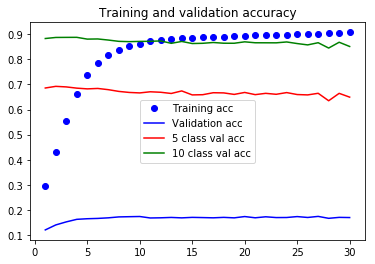

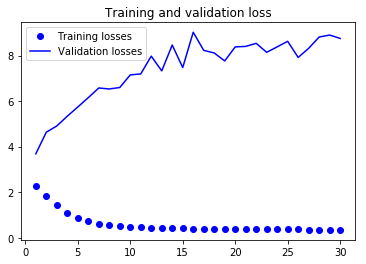

In [7]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
val_5_acc = history.history['val_five_claas_diff']
val_10_acc = history.history['val_ten_claas_diff']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_5_acc, 'r', label='5 class val acc')
plt.plot(epochs, val_10_acc, 'g', label='10 class val acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()